# Wpływ rozmiaru modelu teoretycznego na bias i wariancje 

### Autorzy: Damian Horna 132240 Łukasz Eckert 132218

### 1. Wprowadzenie 
Celem tego notebooka jest pokazanie zależności między biasem a wariancje w modelach SEIRD oraz SIR. Model SEIRD jest modelem posiadającym większą "moc". Posiada dwa dodatkowe parametry które mogą pomóc lepiej dopasować się do danych rzeczywistych. Dlatego też sądzimy, że powinnien mięć mniejszy bias. Co jednak z wariancją? 

### 2. Wariancje 
Stwierdziliśmy, że nałatwiejszym sposobem na policzenie wariancji modelu, jest odporność tego modelu na szum losowy.

In [63]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tqdm 

In [87]:
def deriv_seird(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt
def deriv_sir(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma*I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

Wariancja będzie policzona w następujący sposób:
    1. Losowe parametry każdego modelu zostaną wybrane
    2. Następnie do wybranych parametrów zostanie dodany szum normalny o średniej 0 oraz wariancji 10% długości przedziału wartości
    3. Na danych z szumem zostanie przeprowadzony eksperyment
    4. Krok 2-3 zostaną powtórzony 100 razy.
    5. Wariancja zostanie policzona pomiędzy wszystkim pochodnymi symulacjami dla każdego z dni
    6. Wszystkie powrzysze kroki zostaną powtórzone 100 razy
    7. Średni wynik dla każdego dnia oraz obserwacji zostaną przedstawione na wykresach.

In [112]:
def run_seird():
    N = 60e6 #Stała wartość populacji
    S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed
    num_experiments = 100
    num_noise = 500
    res = []
    for _ in tqdm.tqdm(range(num_experiments)):
        beta = np.random.randint(3)+2 # Same as in UM project 
        delta = 1/(np.random.randint(10)+5)
        alpha = np.random.randint(99)*0.02+0.02
        rho = np.random.randint(11)+9
        gamma = 1/(np.random.randint(6)+4)

        sim = []
        for _ in range(num_noise):
            _beta = max(0, beta+np.random.normal(0, 0.02))
            _delta = max(0, delta+np.random.normal(0, (1/10-1/15)*0.01))
            _alpha = max(0, alpha+np.random.normal(0, 0.0018))
            _rho = max(0, rho+np.random.normal(0, 0.11))
            _gamma = max(0, gamma+np.random.normal(0, (1/4-1/6)*0.01))
            t = np.linspace(0, 46, 46)
            y0 = S0, E0, I0, R0, D0
            ret = odeint(deriv_seird, y0, t, args=(N, _beta, _gamma, _delta, _alpha, _rho))
            sim.append(ret)

        res.append(np.nanvar(np.array(sim),ddof=1, axis=0))
    return np.mean(np.array(res), axis=0)

def run_sir():
    N = 60e6 #Stała wartość populacji
    S0, I0, R0 = N-1, 1, 0  # initial conditions: one exposed
    num_experiments = 100
    num_noise = 500
    res = []
    for _ in tqdm.tqdm(range(num_experiments)):
        beta = np.random.randint(3)+2 # Same as in UM project 
        gamma = 1/(np.random.randint(6)+4)

        sim = []
        for _ in range(num_noise):
            _beta = max(0, beta+np.random.normal(0, 0.02))
            _gamma = max(0, gamma+np.random.normal(0, (1/4-1/6)*0.01))
            t = np.linspace(0, 46, 46)
            y0 = S0,I0, R0
            ret = odeint(deriv_sir, y0, t, args=(N, _beta, _gamma))
            sim.append(ret)

        res.append(np.nanvar(np.array(sim),ddof=1, axis=0))
    return np.mean(np.array(res), axis=0)
    


In [113]:
mean_sir = run_sir()
mean_seird = run_seird()


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


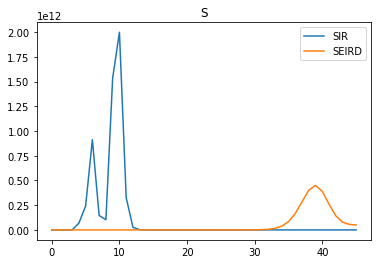

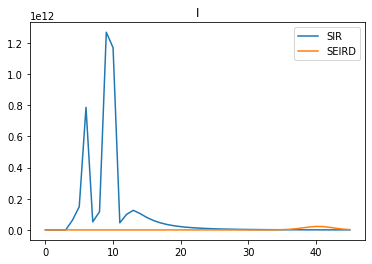

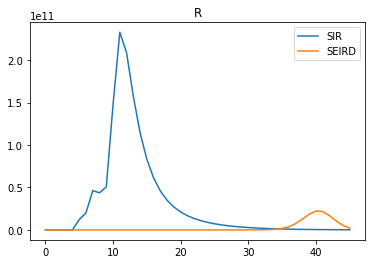

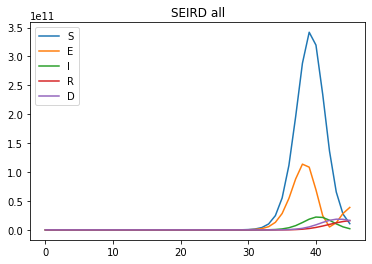

In [105]:
plt.plot(range(46), mean_sir[:, 0], label="SIR")
plt.plot(range(46), mean_seird[:, 0]+mean_seird[:, 1], label="SEIRD")
plt.legend()
plt.title("S")
plt.show()

plt.plot(range(46), mean_sir[:, 1], label="SIR")
plt.plot(range(46), mean_seird[:, 2], label="SEIRD")
plt.legend()
plt.title("I")
plt.show()

plt.plot(range(46), mean_sir[:, 2], label="SIR")
plt.plot(range(46), mean_seird[:, 2], label="SEIRD")
plt.legend()
plt.title("R")
plt.show()

for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(46), mean_seird[:, a], label=name)
plt.legend()
plt.title("SEIRD all")
plt.show()

In [ ]:
# 5,10,15 następnych dni

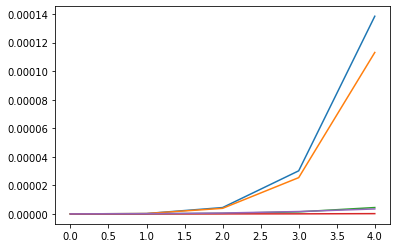

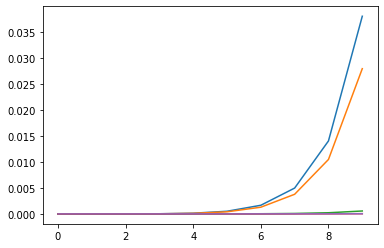

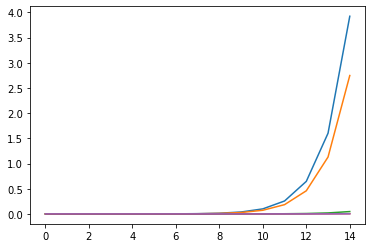

In [127]:
for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(5), mean_seird[:5, a], label=name)
plt.show()
for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(10), mean_seird[:10, a], label=name)
plt.show()
for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(15), mean_seird[:15, a], label=name)